## Procedure

1. Load and clean data
2. Exploratory Data Analysis (EDA)
3. Feature selection
4. Modeling & evaluation

### Load libraries

In [112]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from datetime import datetime
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

### Define classes/functions

In [2]:
class ETL:
    """
    The ETL class contains methods for Extraction, Transformation, Loading. 
    """
    
    def extract_data(path):
        """
        Read CSV (comma-separated) file into DataFrame using the python engine parser.
        """
        df = pd.read_csv(path, engine='python')
        return df
        
    def general_checks(df):
        """
        Perform general checks for nulls, datatypes and unique variables.
        """
        for col in df:
            if len(df[col].unique()) < 10:
                print(col.ljust(15),str(df[col].dtype).ljust(10),str(df[col].isnull().sum()).ljust(5),data[col].unique())
            else:
                print(col.ljust(15),str(df[col].dtype).ljust(10),str(df[col].isnull().sum()).ljust(5),data[col].nunique())

    def convert_and_extract_from_date(df, date_column):
        """
        Convert date column from string to datetime format and extract 'dayofweek' field.
        """
        df[date_column] = pd.to_datetime(df[date_column])
        dayofweek_list = []
        for i in df[date_column]:
            dayofweek_list.append(datetime.weekday(i))
        df['dayofweek'] = pd.Series(dayofweek_list)
        print("Check date datatype: ", df[date_column].dtype)
        print("Check dayofweek datatype: ", df['dayofweek'].dtype)
    
    def deskew_numeric_variables(num_df):
        """
        Deskew numeric variables using log transform.
        """
        logged_df = num_df.copy()
        for col in logged_df.columns:
            logged_df[col] = np.log(1+logged_df[col])
        return logged_df
    
    def encode_categorical_variables(cat_df):
        """
        One-hot encode categorical variables.
        """
        cat_df = cat_df.astype('object')
        print("original size: ", cat_df.shape)
        encoded_cat_df = pd.get_dummies(cat_df)
        print("new size: ", encoded_cat_df.shape)
        return encoded_cat_df
    
    def merge_all_variables(num_df, cat_df, misc_df):
        """
        Merge all variables back together after transformations
        """
        print("numeric variables: ", num_df.shape)
        print("cat_variables: ", cat_df.shape)
        print("misc_variables: ", misc_df.shape)
        transformed_df = pd.concat([num_df,cat_df, misc_df], axis=1)
        transformed_df.rename(columns={0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}, inplace=True)
        return transformed_df
    
    def extract_features_and_target(df):
        """
        Split data into features and target.
        """
        features = df[df.columns[~df.columns.isin(['date','device','failure'])]]
        target = df['failure']
        return features, target
    
class EDA: 
    
    def plot_distribution(num_df):
        fig = plt.figure(figsize=(20,20))
        for i, col in enumerate(num_df.columns):
            fig.add_subplot(3,3,1+i)
            sns.distplot(num_df[col], label=col)
            plt.axvline(num_df[col].mean(), c='r', label = 'mean')
            plt.axvline(num_df[col].median(), c='g', label = 'median')
            plt.axvline(num_df[col].mode()[0], c='b', label = 'mode')
            plt.legend()

    def compare_skew(original_df, logged_df):
        compare_df = pd.DataFrame(columns=['feature', 'original', 'logged'])
        for col in original_df.columns:
            compare_df = compare_df.append({'feature': col,
                                            'original': skew(original_df[col]),
                                            'logged': skew(logged_df[col])}, ignore_index=True)
        return compare_df

    def plot_boxplots(df):
        fig = plt.figure(figsize=(20,20))
        for i, col in enumerate(df.columns):
            fig.add_subplot(6,2,1+i)
            sns.set(style="whitegrid")
            ax = sns.boxplot(x=target, y=df[col])
            
    def plot_correltion_matrix(df):
        corr = df.corr()
        f, ax = plt.subplots(figsize=(20, 9))
        sns.heatmap(corr, vmax=.3, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True)
   
    def plot_pca(features, target):
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        pca = PCA()
        features_pca = pca.fit_transform(scaled_features)
        plt.style.use('ggplot')
        plt.scatter(features_pca[:,0], features_pca[:,1], c=target, alpha=.5)
        plt.colorbar()
        print("# of components needed to account for 90% variance: ", np.where(np.cumsum(pca.explained_variance_ratio_) > .9)[0][0])
        return pca
        
class Modeling:
    
    def evaluate_model(model, X_test, y_test):
        prediction = model.predict(X_test)
        print('Accuracy: ', model.score(X_test, y_test))
        print('F1: ', f1_score(y_test, prediction))
        return pd.DataFrame(confusion_matrix(y_test, prediction))

# 1. Load and clean data

In [3]:
data = ETL.extract_data('../work/data/device_failure.csv')
data.head(2)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0


### Convert and extract from `['date']` column

In [5]:
# I had previously explored the data and saw that there's only data for 
# November 2015, so we only need to extract dayofweek

ETL.convert_and_extract_from_date(data, 'date')

Check date datatype:  datetime64[ns]
Check dayofweek datatype:  int64


## Transformations
Transform numeric and categorical variables so that it feeds in nicely in a way that models can understand. 

**"Garbage in, garbage out"**

Building models on top of raw data wouldn't get us the desired results or performance, as algorithms are not intelligent enough (yet) to automaticaly extract meaningful features from raw data.

In [6]:
# Split numeric & categorical data (create "misc" list just to keep track)

cat_list = ['dayofweek']
num_list = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']
misc_list = ['failure']

### Deskew right-skewed numeric variables only
Use log transform on highly skewed features. Identify which features to apply log transform to by comparing the before and after. Ignore features that are normally distributed or skewed to the left.

* skewness = 0 : normally distributed
* skewness > 0 : right skewed
* skewness < 0 : left skewed

In [7]:
numeric_data = data[num_list]

In [9]:
logged_numeric_data = ETL.deskew_numeric_variables(numeric_data)
logged_numeric_data.head(2)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,19.189078,4.043051,0.000000,3.970292,1.94591,12.917647,0.0,0.0,2.079442
1,17.932443,0.000000,1.386294,0.000000,1.94591,12.907126,0.0,0.0,0.000000


In [12]:
# Pick and choose (exclude left-skewed)

numeric_data = pd.concat([numeric_data[['attribute1','attribute6']],logged_numeric_data[['attribute2','attribute3','attribute4','attribute5','attribute7','attribute8','attribute9']]], axis=1)
numeric_data.head(2)

,attribute1,attribute6,attribute2,attribute3,attribute4,attribute5,attribute7,attribute8,attribute9
0,215630672,407438,4.043051,0.000000,3.970292,1.94591,0.0,0.0,2.079442
1,61370680,403174,0.000000,1.386294,0.000000,1.94591,0.0,0.0,0.000000


### Encode categorical variables
Then merge transformed numeric and categorical features together.

In [13]:
categorical_data = ETL.encode_categorical_variables(data[cat_list])

original size:  (124494, 1)
new size:  (124494, 7)


In [14]:
transformed_data = ETL.merge_all_variables(numeric_data, categorical_data, data[misc_list])
transformed_data.head(2)

numeric variables:  (124494, 9)
cat_variables:  (124494, 7)
misc_variables:  (124494, 1)


,attribute1,attribute6,attribute2,attribute3,attribute4,attribute5,attribute7,attribute8,attribute9,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,failure
0,215630672,407438,4.043051,0.000000,3.970292,1.94591,0.0,0.0,2.079442,0,0,0,1,0,0,0,0
1,61370680,403174,0.000000,1.386294,0.000000,1.94591,0.0,0.0,0.000000,0,0,0,1,0,0,0,0


# 2. Exploratory Data Analysis (EDA)

In [106]:
features, target = ETL.extract_features_and_target(transformed_data)

# 3. Feature Selection

In [26]:
# Drop attribute7, since it is the same as attribute 8

selected_features = features.copy()
selected_features.drop('attribute7', axis=1, inplace=True)

### Use Random Forest to find important features
Random Forest randomly generates a bunch of decision trees and takes turns leaving out each varibale in fitting the model. This way, you can calsulcate how much better or worse a model does when you leave one variable out. 

In [27]:
feats = selected_features.columns.values

rfc = RandomForestClassifier()
rfc.fit(selected_features, target)

print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), feats), reverse=True))

Features sorted by their score:
[(0.2838, 'attribute1'), (0.2351, 'attribute6'), (0.097299999999999998, 'attribute4'), (0.094500000000000001, 'attribute8'), (0.0877, 'attribute2'), (0.0785, 'attribute5'), (0.037499999999999999, 'attribute9'), (0.015599999999999999, 'dayofweek_0'), (0.0138, 'dayofweek_1'), (0.0115, 'dayofweek_4'), (0.0103, 'attribute3'), (0.0095999999999999992, 'dayofweek_3'), (0.0094999999999999998, 'dayofweek_2'), (0.0091999999999999998, 'dayofweek_5'), (0.0058999999999999999, 'dayofweek_6')]


In [28]:
# Drop attributes 3&9, since they're constantly at the bottom

selected_features.drop(['attribute3','attribute9'], axis=1, inplace=True)

### Use Select K Best to find important features

In [118]:
from sklearn.feature_selection import SelectKBest, SelectFromModel

In [32]:
# Import score function for a regressor:
from sklearn.feature_selection import f_regression

# Instantiate a SelectKBest object with scoring funcion and how many columns you want to select
skb = SelectKBest(score_func=f_regression, k=5) #this narrows down our features space

skb.fit(features, target)

# To observe scores, zip column names and scores, then sort them in descending order.
feat_list = list(zip(features.columns,skb.scores_, skb.pvalues_))
feat_list.sort(key=lambda x: x[2], reverse=False)
pd.DataFrame(feat_list, columns=['feature','f-score','p-value'])

#look at the f-score, seems like we can take the top four features.

,feature,f-score,p-value
0,attribute7,1745.630794,0.000000e+00
1,attribute8,1745.630794,0.000000e+00
2,attribute4,658.414298,7.890052e-145
3,attribute2,467.364828,1.862268e-103
4,dayofweek_0,10.634488,1.110278e-03
5,dayofweek_6,9.650078,1.893861e-03
6,dayofweek_5,4.019026,4.499186e-02
7,dayofweek_3,3.258028,7.107698e-02
8,attribute9,2.538821,1.110802e-01
9,attribute5,2.283751,1.307379e-01


In [30]:
# Only keep attributes 8,4,2

selected_features2 = selected_features[['attribute8', 'attribute4', 'attribute2']]

### Principal Component Analysis (PCA)
Use the first two principal components to visualize the data.

# of components needed to account for 90% variance:  2


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

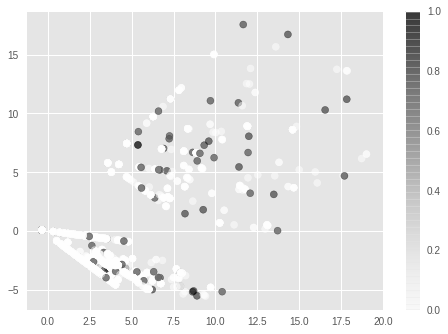

In [32]:
EDA.plot_pca(selected_features2, target)

# of components needed to account for 90% variance:  11


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

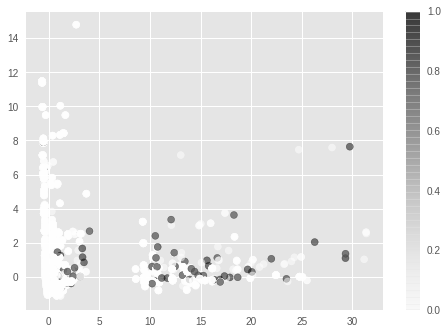

In [29]:
EDA.plot_pca(features, target)

# of components needed to account for 90% variance:  10


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

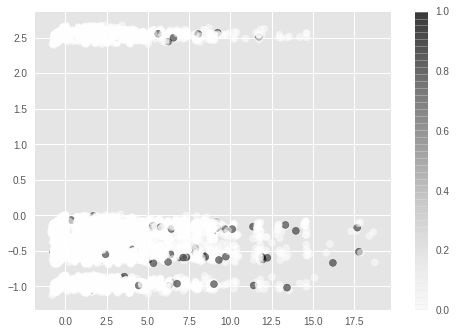

In [30]:
EDA.plot_pca(selected_features, target)

# 5. Modeling & evaluation

### Generate training and test data

In [107]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=33)

In [108]:
sm = SMOTE(random_state=88, ratio = 1.0)
X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)

## Logistic Regression
Draws a line (hyperplane) between different classes of points. The further a point is from the boundary line, the more its score (estimate) increases (nearing 0 or 1). Do a simple Logistic Regression on scaled and non-scaled data just to see which performs better.

In [109]:
from sklearn.linear_model import Lasso

In [173]:
lg1 = make_pipeline(SelectKBest(score_func=f_regression, k=2),
                   StandardScaler(),
                   LogisticRegression())
lg1.fit(X_train, y_train)
print("\n")
Modeling.evaluate_model(lg1, X_test, y_test)



Accuracy:  0.999196765643
F1:  0.0625


,0,1
0,37318,0
1,30,1


In [212]:
lg1 = make_pipeline(SelectKBest(score_func=f_regression, k=2),
                   StandardScaler(),
                   LogisticRegression())
lg1.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(lg1, X_test, y_test)



Accuracy:  0.929288602104
F1:  0.015654118524


,0,1
0,34687,2631
1,10,21


In [169]:
# Did worse on resampled data

lg2 = make_pipeline(SelectKBest(score_func=f_regression, k=2),
                    LogisticRegression())
lg2.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(lg2, X_test, y_test)



Accuracy:  0.929288602104
F1:  0.015654118524


,0,1
0,34687,2631
1,10,21


In [38]:
# Did worse on resampled data

lg2 = make_pipeline(StandardScaler(),
                    PCA(),
                    LogisticRegression())
lg2.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(lg2, X_test, y_test)



Accuracy:  0.921416905406
F1:  0.0154310634015


,0,1
0,34391,2927
1,8,23


## Decision Tree
Recursively subdivides the instance space into finer and finer subregions until it is all one class (or good enough). New instances start at the root node and takes the appropriate path until it reaches a lead node, which determines the classification by checking the classes of the training instances that reached that leaf, and the majority determines the class. For that leaf, the score is calculated by:

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{majority&space;instances}{(majority&space;instances&space;&plus;&space;minority&space;instances)&space;}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{majority&space;instances}{(majority&space;instances&space;&plus;&space;minority&space;instances)&space;}" title="\frac{majority instances}{(majority instances + minority instances) }" /></a>

When using scikit-learn's DecisionTreeClassifier, always set min_samples_leaf to something like 5 or 10. Its default value of 1 is useless and is guaranteed to overfit. 

In [179]:
dt1 = make_pipeline(SelectKBest(score_func=f_regression, k=2),
                    StandardScaler(),
                    PCA(),
                    DecisionTreeClassifier(min_samples_leaf=10))
dt1.fit(X_train, y_train)
print("\n")
Modeling.evaluate_model(dt1, X_test, y_test)



Accuracy:  0.999169991164
F1:  0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1
0,37318,0
1,31,0


In [222]:
dt1 = make_pipeline(SelectKBest(score_func=f_regression, k=3),
                    StandardScaler(),
                    PCA(),
                    DecisionTreeClassifier(min_samples_leaf=2))
dt1.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(dt1, X_test, y_test)



Accuracy:  0.998982569814
F1:  0.208333333333


,0,1
0,37306,12
1,26,5


In [206]:
dt2 = make_pipeline(SelectKBest(score_func=f_regression, k=2),
                    StandardScaler(),
                    PCA(),
                    DecisionTreeClassifier(min_samples_leaf=2))
dt2.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(dt2, X_test, y_test)



Accuracy:  0.998955795336
F1:  0.204081632653


,0,1
0,37305,13
1,26,5


In [211]:
dt2 = make_pipeline(SelectKBest(score_func=f_regression, k=3),
                    StandardScaler(),
                    PCA(),
                    DecisionTreeClassifier())
dt2.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(dt2, X_test, y_test)



Accuracy:  0.998982569814
F1:  0.208333333333


,0,1
0,37306,12
1,26,5


## Random Forest

In [208]:
rf1 = make_pipeline(SelectKBest(score_func=f_regression, k=2),
                    StandardScaler(),
                    RandomForestClassifier())
rf1.fit(X_train, y_train)
print("\n")
Modeling.evaluate_model(rf1, X_test, y_test)



Accuracy:  0.999169991164
F1:  0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1
0,37318,0
1,31,0


In [215]:
rf1 = make_pipeline(SelectKBest(score_func=f_regression, k=2),
                    StandardScaler(),
                    RandomForestClassifier())
rf1.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(rf1, X_test, y_test)



Accuracy:  0.998768373986
F1:  0.08


,0,1
0,37301,17
1,29,2


Warning explanation: when the model doesn't predict positive class at all, precision and recall are 0. That means you are dividing 0/0.

In [97]:
rf2 = make_pipeline(StandardScaler(),
                    PCA(n_components=11),
                    RandomForestClassifier())
rf2.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(rf2, X_test, y_test)



Accuracy:  0.997911590672
F1:  0.0487804878049


,0,1
0,37269,49
1,29,2


In [42]:
rf2 = make_pipeline(StandardScaler(),
                    PCA(),
                    RandomForestClassifier())
rf2.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(rf2, X_test, y_test)



Accuracy:  0.998527403679
F1:  0.0


,0,1
0,37294,24
1,31,0


### K-Nearest Neighbor
If for example, `k=5`, for every new instance, 5 of its nearest neighbors are randomly selected and some function like majority is applied to the five neighbors. To assign a score, divide the number of positive instances by the total and return the fraction. 

In [99]:
knn1 = make_pipeline(StandardScaler(),
                     PCA(n_components=11),
                     KNeighborsClassifier())
knn1.fit(X_train, y_train)
print("\n")
Modeling.evaluate_model(knn1, X_test, y_test)



Accuracy:  0.999116442207
F1:  0.0


,0,1
0,37316,2
1,31,0


In [43]:
knn1 = make_pipeline(StandardScaler(),
                     PCA(),
                     KNeighborsClassifier())
knn1.fit(X_train, y_train)
print("\n")
Modeling.evaluate_model(knn1, X_test, y_test)



Accuracy:  0.999089667729
F1:  0.0


,0,1
0,37315,3
1,31,0


In [101]:
knn2 = make_pipeline(StandardScaler(),
                     PCA(n_components=12),
                     KNeighborsClassifier())
knn2.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(knn2, X_test, y_test)



Accuracy:  0.996278347479
F1:  0.027972027972


,0,1
0,37208,110
1,29,2


In [44]:
knn2 = make_pipeline(StandardScaler(),
                     PCA(),
                     KNeighborsClassifier())
knn2.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(knn2, X_test, y_test)



Accuracy:  0.996653190179
F1:  0.031007751938


,0,1
0,37222,96
1,29,2


In [103]:
xgb1 = make_pipeline(StandardScaler(),
                     PCA(n_components=12),
                     XGBClassifier())
xgb1.fit(X_train, y_train)
print("\n")
Modeling.evaluate_model(xgb1, X_test, y_test)



Accuracy:  0.999169991164
F1:  0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1
0,37318,0
1,31,0


In [45]:
xgb1 = make_pipeline(StandardScaler(),
                     PCA(),
                     XGBClassifier())
xgb1.fit(X_train, y_train)
print("\n")
Modeling.evaluate_model(xgb1, X_test, y_test)



Accuracy:  0.999143216686
F1:  0.0


,0,1
0,37317,1
1,31,0


In [105]:
xgb2 = make_pipeline(StandardScaler(),
                     PCA(n_components=12),
                     XGBClassifier())
xgb2.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(xgb2, X_test, y_test)



Accuracy:  0.961685721171
F1:  0.0151410874054


,0,1
0,35907,1411
1,20,11


In [46]:
xgb2 = make_pipeline(StandardScaler(),
                     PCA(),
                     XGBClassifier())
xgb2.fit(X_train_resampled, y_train_resampled)
print("\n")
Modeling.evaluate_model(xgb2, X_test, y_test)



Accuracy:  0.962033789392
F1:  0.0193637621024


,0,1
0,35917,1401
1,17,14


# Our best model: DecisionTreeClassifier on resampled data